<a href="https://colab.research.google.com/github/lelouch0204/Wind-speed-time-series-analysis/blob/main/asm_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts
!pip install distfit

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf 
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries
from distfit import distfit

In [3]:
data_root = '/content/drive/MyDrive/renewable_energy_data/'
data_root_list = sorted(os.listdir(data_root))
data_root_list_paths = [data_root+x for x in data_root_list if x.find('parsed')!=-1]
print(data_root_list_paths)

['/content/drive/MyDrive/renewable_energy_data/Rajasthan1_parsed.csv', '/content/drive/MyDrive/renewable_energy_data/Rajasthan2_parsed.csv', '/content/drive/MyDrive/renewable_energy_data/Rajasthan3_parsed.csv', '/content/drive/MyDrive/renewable_energy_data/Rajasthan4_parsed.csv', '/content/drive/MyDrive/renewable_energy_data/Rajasthan5_parsed.csv']


In [4]:
df1 = pd.read_csv(data_root_list_paths[0])
df1.drop(columns=['Unnamed: 18', 'Unnamed: 0'], inplace=True)
print(df1)

        Year  Month  Day  ...  Solar Zenith Angle  Snow Depth  Wind Speed
0       2000      1    1  ...          174.755997           0    3.976945
1       2000      1    1  ...          169.544205           0    4.017371
2       2000      1    1  ...          156.340938           0    3.992325
3       2000      1    1  ...          142.945864           0    3.981812
4       2000      1    1  ...          129.625767           0    3.985008
...      ...    ...  ...  ...                 ...         ...         ...
131395  2014     12   31  ...          109.345042           0    5.375054
131396  2014     12   31  ...          122.334314           0    5.473386
131397  2014     12   31  ...          135.562509           0    5.500148
131398  2014     12   31  ...          148.928152           0    5.481440
131399  2014     12   31  ...          162.301237           0    5.428378

[131400 rows x 18 columns]


# Descriptive Statistics

We use the data for Region 1 to generate descriptive statistics about the variables present.

In [5]:
variables = ['DHI', 'DNI', 'GHI', 'Dew Point', 'Temperature', 'Pressure',
     'Relative Humidity', 'Wind Speed']
desc_df = df1[variables].describe(include='all')
desc_df

,DHI,DNI,GHI,Dew Point,Temperature,Pressure,Relative Humidity,Wind Speed
count,131400.000000,131400.000000,131400.000000,131400.000000,131400.000000,131400.000000,131400.000000,131400.000000
mean,96.772702,207.312869,237.890068,7.843516,28.197716,978.962455,34.840594,3.010992
std,119.406250,275.825066,315.345071,11.962141,8.433940,6.560678,23.262578,1.459902
min,0.000000,0.000000,0.000000,-37.000000,4.366332,962.749817,0.355050,0.003498
25%,0.000000,0.000000,0.000000,-2.000000,22.629722,973.255051,16.397738,1.922849
50%,0.000000,0.000000,0.000000,7.000000,28.722314,979.304504,27.583978,2.886465
75%,195.000000,490.000000,501.000000,20.000000,33.871842,984.585770,49.744047,3.950299
max,735.000000,838.000000,995.000000,28.000000,51.817446,995.741089,100.000000,9.521152


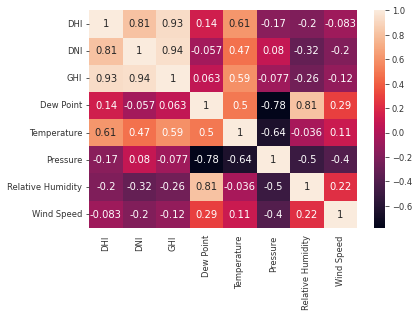

In [6]:
ax = sns.heatmap(df1[variables].corr(), annot=True)

In [7]:
df_date_parse = df1['Year'].astype(str) + '-' + df1['Month'].astype(str) + '-' + df1['Day'].astype(str) + " " + df1['Hour'].astype(str) + ":" + df1['Minute'].astype(str) 
df1["Date"] = pd.to_datetime(df_date_parse)
df1.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0172165] [loc=3.011 scale=1.460]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.4599068] [loc=0.003 scale=3.007]
[distfit] >[pareto    ] [8.79 sec] [RSS: 0.5096535] [loc=-9673571.678 scale=9673571.682]
[distfit] >[dweibull  ] [2.92 sec] [RSS: 0.0349092] [loc=2.981 scale=1.264]
[distfit] >[t         ] [2.40 sec] [RSS: 0.0172224] [loc=3.011 scale=1.460]
[distfit] >[genextreme] [2.42 sec] [RSS: 0.0042741] [loc=2.399 scale=1.298]
[distfit] >[gamma     ] [1.38 sec] [RSS: 0.0041380] [loc=-1.328 scale=0.503]
[distfit] >[lognorm   ] [5.90 sec] [RSS: 0.0048046] [loc=-3.731 scale=6.587]
[distfit] >[beta      ] [2.07 sec] [RSS: 0.0015825] [loc=-0.179 scale=10.849]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.4695490] [loc=0.003 scale=9.518]
[distfit] >[loggamma  ] [5.87 sec] [RSS: 0.0178180] [loc=-453.856 scale=61.266]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nbeta\na=3.05, b=7.33, loc=-0.18, scale=10.85'}, xlabel='Values', ylabel='Frequency'>)

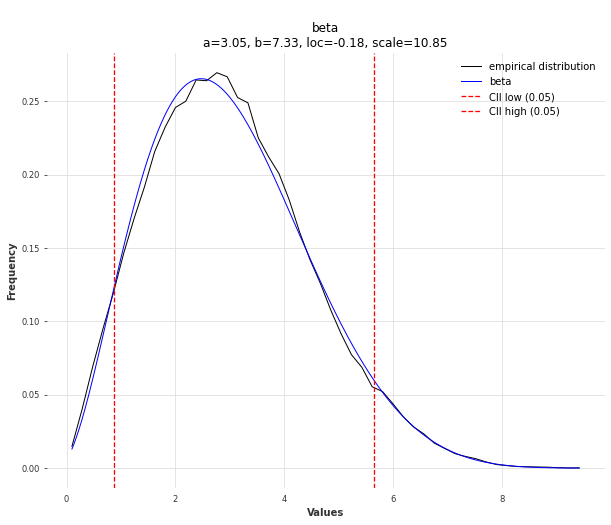

In [8]:
dist = distfit()
results = dist.fit_transform(df1['Wind Speed'])
dist.plot()

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm] [0.00 sec] [RSS: 0.0172165] [loc=3.011 scale=1.460]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nnorm\nloc=3.01, scale=1.46'}, xlabel='Values', ylabel='Frequency'>)

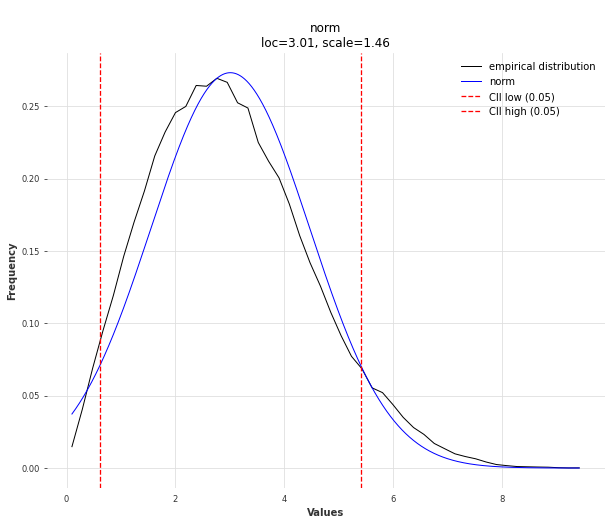

In [9]:
dist_norm = distfit(distr='norm')
results_norm = dist_norm.fit_transform(df1['Wind Speed'])
dist_norm.plot()

In [10]:
df_day = df1.resample('1D', on='Date').mean()

In [11]:
df_day = df_day.fillna(method='ffill')
df_day.isnull().sum()

DHI                   0
DNI                   0
GHI                   0
Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Dew Point             0
Temperature           0
Pressure              0
Relative Humidity     0
Solar Zenith Angle    0
Snow Depth            0
Wind Speed            0
dtype: int64

In [12]:
##Make a weekly time series plot
"""
temp_day = df1['Wind Speed'].groupby(np.arange(len(df1))//24).mean()
temp_day
daily_series = pd.date_range(start="2000-01-01", periods=len(temp_day), freq="D")
daily_series
df_day = pd.Series(data=temp_day['Wind Speed'], index=daily_series)
"""
df_day["Date"] = df_day.index
df_day["Date"]

Date
2000-01-01   2000-01-01
2000-01-02   2000-01-02
2000-01-03   2000-01-03
2000-01-04   2000-01-04
2000-01-05   2000-01-05
                ...    
2014-12-27   2014-12-27
2014-12-28   2014-12-28
2014-12-29   2014-12-29
2014-12-30   2014-12-30
2014-12-31   2014-12-31
Freq: D, Name: Date, Length: 5479, dtype: datetime64[ns]

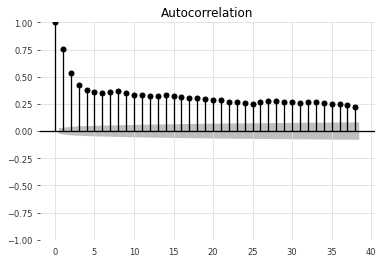

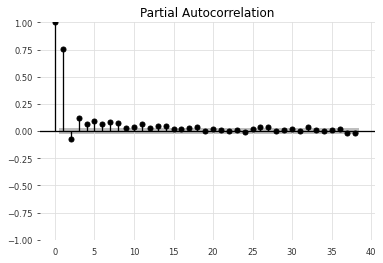

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_day['Wind Speed'])
plot_pacf(df_day['Wind Speed'])
plt.show()

# Autoregressive model

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

train_len = int(0.8*len(df_day))
test_len = len(df_day)-train_len
np_ar = df_day['Wind Speed'].to_numpy()
train_ar, test_ar = np_ar[:train_len], np_ar[train_len:]
ar_model = AutoReg(np_ar, lags=1)
ar_fit = ar_model.fit()
coeff_ar = ar_fit.params
pred_ar = ar_model.predict(coeff_ar, start=1, end=len(np_ar)-1, dynamic=False)
mae_ar = np.mean(np.abs(pred_ar - np_ar[1:]))
print("MAE for Autoregressive model is", mae_ar)
print(ar_fit.summary())
train_pred_ar = np.concatenate((train_ar, pred_ar))
plt.plot(range(30), np_ar[-30:], label="Actual values")
plt.plot(range(30), pred_ar[-30:], label="Predicted values")
plt.legend()
plt.show()

# Moving Average


[3.01064642 3.25642515 3.01944961 ... 3.03162089 2.83031682 3.64205442]
MAE for moving average model is 0.6608036545765761
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5479
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -6811.263
Date:                Mon, 06 Dec 2021   AIC                          13632.525
Time:                        09:31:35   BIC                          13665.568
Sample:                             0   HQIC                         13644.053
                               - 5479                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0106      0.030    101.635      0.000       2.953       3.069
ma.L1   

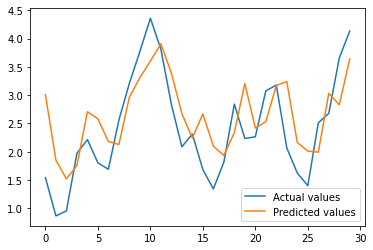

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults

ma_model = ARIMA(np_ar, order=(0, 0, 3))
ma_fit = ma_model.fit()
coeff_ma = ma_fit.params
pred_ma = ma_fit.predict(start=0, end=len(np_ar)-1)
print(pred_ma)
mae_ma = np.mean(np.abs(pred_ma[-30:] - test_ar[-30:])/np.abs(np_ar[-30:]))
print("MAE for moving average model is", ma_fit.mae)
print(ma_fit.summary())
##train_pred_ma = np.concatenate((train_ar, pred_ma))
plt.plot(range(30), test_ar[-30:], label="Actual values")
plt.plot(range(30), pred_ma[-30:], label="Predicted values")
plt.legend()
plt.show()

[3.00747411 3.27767007 3.06841199 ... 2.69289954 2.57033568 3.28941239]
MAE for ARMA model is 0.6259790759834045
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5479
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -6549.476
Date:                Mon, 06 Dec 2021   AIC                          13110.952
Time:                        09:30:57   BIC                          13150.604
Sample:                             0   HQIC                         13124.786
                               - 5479                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0075      0.109     27.567      0.000       2.794       3.221
ar.L1          0.9

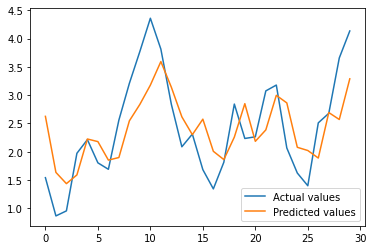

In [ ]:
ma_model = ARIMA(np_ar, order=(1, 0, 3))
ma_fit = ma_model.fit()
coeff_ma = ma_fit.params
pred_ma = ma_fit.predict(start=0, end=len(np_ar)-1)
print(pred_ma)
mae_ma = np.mean(np.abs(pred_ma[-30:] - test_ar[-30:])/np.abs(np_ar[-30:]))
print("MAE for ARMA model is", ma_fit.mae)
print(ma_fit.summary())
##train_pred_ma = np.concatenate((train_ar, pred_ma))
plt.plot(range(30), test_ar[-30:], label="Actual values")
plt.plot(range(30), pred_ma[-30:], label="Predicted values")
plt.legend()
plt.show()

In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
def sarima_params(): 
    models = list() 
    # define config lists 
    p_params = [0, 1, 2] 
    d_params = [0, 1] 
    q_params = [0, 1, 2] 
    t_params = ['c'] 
    P_params = [0, 1, 2] 
    D_params = [0, 1] 
    Q_params = [0, 1, 2] 
    m_params = [0] 
    # create config instances 
    for p in p_params: 
        for d in d_params: 
            for q in q_params: 
                for t in t_params: 
                    for P in P_params: 
                        for D in D_params: 
                            for Q in Q_params: 
                                for m in m_params: 
                                    cfg = [(p,d,q), (P,D,Q,m), t] 
                                    models.append(cfg) 
    return models

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

def sarima_pred(data, params):
    order, seas, trend = params
    try:
        model = SARIMAX(data, order=order, seasonal_order=seas, trend=trend)
        model_fit = model.fit()
        model_pred = model_fit.predict(start=0, end=len(np_ar)-1)
        ret_dict = {
            'mae' : model_fit.mae,
            'params' : params,
        }
        return ret_dict
    except:
        return None

In [ ]:
def grid_search(models):
    best_score = 1000
    best_params = None
    for model in models:
        ret_dict = sarima_pred(np_ar, model)
        if ret_dict is not None:
            if best_score > ret_dict['mae']:
                best_params = ret_dict

    return best_params

In [ ]:
best_params = grid_search(sarima_params())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
print(best_params)

{'mae': 0.6242495101448439, 'params': [(2, 1, 2), (0, 0, 0, 0), 'c']}


In [ ]:
sarima_model = SARIMAX(np_ar, order=best_params['params'][0], seasonal_order=(1, 1, 1, 365), trend=best_params['params'][2])
sarima_fit = sarima_model.fit()
coeff_sarima = sarima_fit.params
pred_sarima = sarima_fit.predict(start=0, end=len(np_ar)-1)
print("MAE for SARIMA model is", sarima_fit.mae)
print(sarima_fit.summary())
plt.plot(range(30), test_ar[-30:], label="Actual values")
plt.plot(range(30), pred_sarima[-30:], label="Predicted values")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

